In [1]:
import os
os.environ["THEANO_FLAGS"] = "device=gpu1"
from lasagne.generative.autoencoder import Autoencoder, greedy_learn_with_validation

from lasagne.easy import BatchOptimizer, LightweightModel
from lasagne.datasets.mnist import MNIST

from sklearn.utils import shuffle


from sklearn.cross_validation import train_test_split

from lasagne import layers, updates, init, nonlinearities
import theano.tensor as T
from theano.sandbox import rng_mrg
import theano
import matplotlib.pyplot as plt
import numpy as np
from lasagne.layers import get_all_layers

from skimage.io import imread
from skimage.filter import threshold_otsu
from skimage.transform import resize

import matplotlib.pyplot as plt

from lasagne import easy

from lasagne.generative.capsule import Capsule
from lasagne.easy import BatchIterator
import glob
import os

from lasagne.easy import BatchOptimizer, LightweightModel
from lasagne import init
from collections import OrderedDict
from lasagne import init, layers, updates, nonlinearities
from lasagne.layers.helper import get_all_layers
from lasagne.layers import helper
import theano.tensor as T
from theano.sandbox import rng_mrg
from sklearn.cross_validation import train_test_split
from lasagne.datasets.fonts import Fonts
import theano
from collections import OrderedDict
import theano.tensor as T

from lasagne.generative.capsule import Capsule
from lasagne.layers import Layer
from sklearn.preprocessing import label_binarize
from skimage.filter import threshold_otsu
from skimage.transform import resize
from lasagne.layers import cuda_convnet, Conv2DLayer

%matplotlib inline


def binarize(X):
    X_b = np.empty(X.shape, dtype=X.dtype)
    for i in range(X.shape[0]):
        X_b[i] = 1. * (X[i] <= threshold_otsu(X[i]))
    return X_b

def resize_all(X, w, h):
    if X.shape[1] == w and X.shape[2] == h:
        return X
    X_b = np.empty((X.shape[0], w, h), dtype=X.dtype)
    for i in range(X.shape[0]):
        X_b[i] = resize(X[i], (w, h))
    return X_b  

class SumLayer(Layer):
    def __init__(self, 
                 incoming,
                 axis=1,
                 **kwargs):
        super(SumLayer, self).__init__(incoming, **kwargs)
        self.axis = axis

    def get_output_for(self, input, **kwargs):
        return input.sum(axis=self.axis)
    
    def get_output_shape_for(self, input):
        shape = list(self.input_shape)
        del shape[self.axis]
        return tuple(shape)

class Model:
    def get_all_params(self, **t):
        return list(set(self.x_to_z.get_all_params(**t) + 
                        self.x_to_y.get_all_params(**t) + 
                        self.z_to_x.get_all_params(**t)))

def cross_correlation(a, b):
    a = a - a.mean(axis=0)
    b = b - b.mean(axis=0)
    return 0.5 * ((((a.dimshuffle(0, 'x', 1) * b.dimshuffle(0, 1, 'x'))).mean(axis=0))**2).sum()

%matplotlib inline

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 1: Tesla K20m


# Seed

In [2]:
seed = 1234
np.random.seed(seed)

# Load & pre-process data

In [3]:
dataset = "fonts"

In [4]:

if dataset == "mnist":
    data = MNIST()
    data.load()
    X = data.X
    X = X.astype(np.float32)
    y = data.y.astype(np.int32)
    real_w, real_h = 28, 28
    output_dim = 10
elif dataset == "fonts":
    data = Fonts(kind="all_64", labels_kind="letters")
    data.load()
    X = data.X
    X = X.astype(np.float32)
    y = data.y.astype(np.int32)
    output_dim = 26
    real_w, real_h = 64, 64
    X=1-X
    
y = label_binarize(y, np.arange(output_dim))
y = y.astype(np.float32)

In [5]:
w, h = 28, 28 # Desired resolution (if necessary the images will be resize to fit w and h)

In [6]:

binarize = False # binarize the images if "True"

if (w, h) != (real_w, real_h):
    X_b = np.zeros((X.shape[0], w, h))
    for i in range(X_b.shape[0]):
        X_b[i] = resize(X[i].reshape((real_w, real_h)), (w, h))
    X = X_b
    if binarize is True:
        X = X <= threshold_otsu(X)
        X = 1 - X
    
    X = X.reshape((X.shape[0], w*h))
    X = X.astype(np.float32)

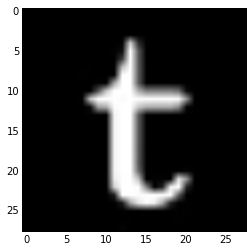

In [7]:
plt.imshow(X[1].reshape((w, h)), cmap="gray")

In [7]:
X, y = shuffle(X, y)
train, test = train_test_split(range(X.shape[0]), test_size=0.25)

In [8]:

nb_samples_for_learning_curve = 1000
nb_tries_learning_curve = 10

class MyBatchOptimizer(BatchOptimizer):
    
    def iter_update(self, epoch, nb_batches, iter_update_batch):
        status = super(MyBatchOptimizer, self).iter_update(epoch, nb_batches, iter_update_batch)
        
        all_of_them = [
            "acc_train",
            "acc_valid",
            "rec_train",
            "rec_valid",
            "crosscor_train",
            "crosscor_valid"
        ]
        for a in all_of_them:
            status[a] = 0.
        for i in range(nb_tries_learning_curve):
        
            s = np.arange(len(train))
            np.random.shuffle(s)
            s_train = s[0:nb_samples_for_learning_curve]


            s = np.arange(len(test))
            np.random.shuffle(s)
            s_test = s[0:nb_samples_for_learning_curve]


            status["acc_train"] += (self.model.predict(X[train][s_train])==y[train][s_train].argmax(axis=1)).mean()
            status["acc_valid"] += (self.model.predict(X[test][s_test])==y[test][s_test].argmax(axis=1)).mean()

            status["rec_train"] += self.model.get_reconstruction_error(X[train][s_train])
            status["rec_valid"] += self.model.get_reconstruction_error(X[test][s_test])

            status["crosscor_train"] += self.model.get_cross_correlation(X[train][s_train])
            status["crosscor_valid"] += self.model.get_cross_correlation(X[test][s_test])
        for a in all_of_them:
            status[a] /= nb_tries_learning_curve
        return status

## Model definition

## model type

In [9]:
model_type = "convnet" # or "convnet"

### Fully connected

In [10]:
if model_type == "fully_connected":
    ## fully connected
    latent_size = 4
    num_hidden_units = 1000

    l_in = layers.InputLayer((None, w*h))
    input_dim = w*h
    output_dim = y.shape[1]

    # encoder
    l_encoder1 = layers.DenseLayer(l_in, num_units=num_hidden_units)
    l_encoder2 = layers.DenseLayer(l_encoder1, num_units=num_hidden_units)
    l_encoder3 = layers.DenseLayer(l_encoder2, num_units=num_hidden_units)
    l_encoder4 = layers.DenseLayer(l_encoder3, num_units=num_hidden_units)
    l_encoder4 = layers.DenseLayer(l_encoder4, num_units=num_hidden_units)


    # learned representation
    l_observed = layers.DenseLayer(l_encoder4, num_units=output_dim,
                                      nonlinearity=T.nnet.softmax)

    l_latent = layers.DenseLayer(l_encoder4, 
                                 num_units=latent_size,
                                 nonlinearity=None) # linear

    l_representation = layers.concat([l_observed, l_latent])

    # decoder
    l_decoder1 = layers.DenseLayer(l_representation, num_units=num_hidden_units)
    l_decoder2 = layers.DenseLayer(l_decoder1, num_units=num_hidden_units)
    l_decoder3 = layers.DenseLayer(l_decoder2, num_units=num_hidden_units)
    l_decoder4 = layers.DenseLayer(l_decoder3, num_units=num_hidden_units)
    l_encoder4 = layers.DenseLayer(l_encoder4, num_units=num_hidden_units)

    l_decoder_out = layers.DenseLayer(l_decoder4, num_units=input_dim,
                                       nonlinearity=nonlinearities.sigmoid)

    x_to_z = LightweightModel([l_in], [l_latent])
    x_to_y = LightweightModel([l_in], [l_observed])
    z_to_x = LightweightModel([l_observed, l_latent], [l_decoder_out])
    model = Model()
    model.x_to_z = x_to_z
    model.x_to_y = x_to_y
    model.z_to_x = z_to_x

### Convnet

In [11]:
if model_type == "convnet":
    deconv = True
    ## CNN
    latent_size = 50
    nb_filters=64
    size_filters=3
    nb_hidden=1000
    nb_filters_encoder = nb_filters
    nb_filters_decoder = nb_filters
    size_filters_encoder = size_filters
    size_filters_decoder = size_filters

    l_in = layers.InputLayer((None, w*h))


    x_in_reshaped = layers.ReshapeLayer(l_in, ([0], 1, w, h))

    # conv1
    l_conv = cuda_convnet.Conv2DCCLayer(
        x_in_reshaped,
        num_filters=nb_filters_encoder,
        filter_size=(size_filters, size_filters_encoder),
        nonlinearity=nonlinearities.rectify,
        dimshuffle=True,
    )
 
    l_hid = layers.DenseLayer(
        l_conv,
        num_units=nb_hidden,
        nonlinearity=nonlinearities.rectify,
    )
    
    l_hid = layers.DenseLayer(
        l_hid,
        num_units=nb_hidden,
        nonlinearity=nonlinearities.rectify,
    )
        
  


    #code layer

    l_observed = layers.DenseLayer(l_hid, 
                                   num_units=output_dim,
                                    nonlinearity=T.nnet.softmax)

    l_latent = layers.DenseLayer(l_hid, 
                                 num_units=latent_size,
                                 nonlinearity=None) # linear

    hid = layers.ConcatLayer([l_latent, l_observed], axis=1)

    l_hid = layers.DenseLayer(
        hid,
        num_units=nb_hidden,
        nonlinearity=nonlinearities.rectify,
    )
    
    l_hid = layers.DenseLayer(
        l_hid,
        num_units=nb_hidden,
        nonlinearity=nonlinearities.rectify,
    )
    
        
 
    if deconv is True:

        # unflatten layer
        hid = layers.DenseLayer(l_hid,
                                num_units=nb_filters_decoder * (w - size_filters_decoder + 1) * (h - size_filters_decoder + 1))
        hid = layers.ReshapeLayer(hid,
                                  ([0], nb_filters_decoder, (w - size_filters_decoder + 1), (h - size_filters_decoder + 1)))

        l_unconv = Conv2DLayer(
            hid,
            num_filters=32,
            filter_size=(size_filters_decoder, size_filters_decoder),
            nonlinearity=nonlinearities.linear,
            border_mode="full"
        )
        l_unconv_sum = SumLayer(l_unconv, axis=1)
        l_decoder_out = layers.ReshapeLayer(l_unconv_sum, ([0], w*h))
        l_decoder_out = layers.NonlinearityLayer(l_decoder_out, nonlinearities.sigmoid)

    else:
        l_decoder_out = layers.DenseLayer(l_hid, num_units=w*h, nonlinearity=nonlinearities.sigmoid)

        

    x_to_z = LightweightModel([l_in], [l_latent])
    x_to_y = LightweightModel([l_in], [l_observed])
    z_to_x = LightweightModel([l_observed, l_latent], [l_decoder_out])
    model = Model()
    model.x_to_z = x_to_z
    model.x_to_y = x_to_y
    model.z_to_x = z_to_x

/home/gridcl/mehdicherti/work/code/Lasagne/lasagne/init.py:91: UserWarning: The uniform initializer no longer uses Glorot et al.'s approach to determine the bounds, but defaults to the range (-0.01, 0.01) instead. Please use the new GlorotUniform initializer to get the old behavior. GlorotUniform is now the default for all layers.
  warnings.warn("The uniform initializer no longer uses Glorot et al.'s "


## Visualization of the model

/home/gridcl/mehdicherti/work/code/Lasagne/lasagne/layers/helper.py:69: UserWarning: get_all_layers() has been changed to return layers in topological order. The former implementation is still available as get_all_layers_old(), but will be removed before the first release of Lasagne. To ignore this warning, use `warnings.filterwarnings('ignore', '.*topo.*')`.
  warnings.warn("get_all_layers() has been changed to return layers in "
/home/gridcl/mehdicherti/work/code/Lasagne/lasagne/misc/draw_net.py:89: UserWarning: layer.get_output_shape() is deprecated and will be removed for the first release of Lasagne. Please use layer.output_shape instead.
  'Output shape: {0}'.format(layer.get_output_shape())


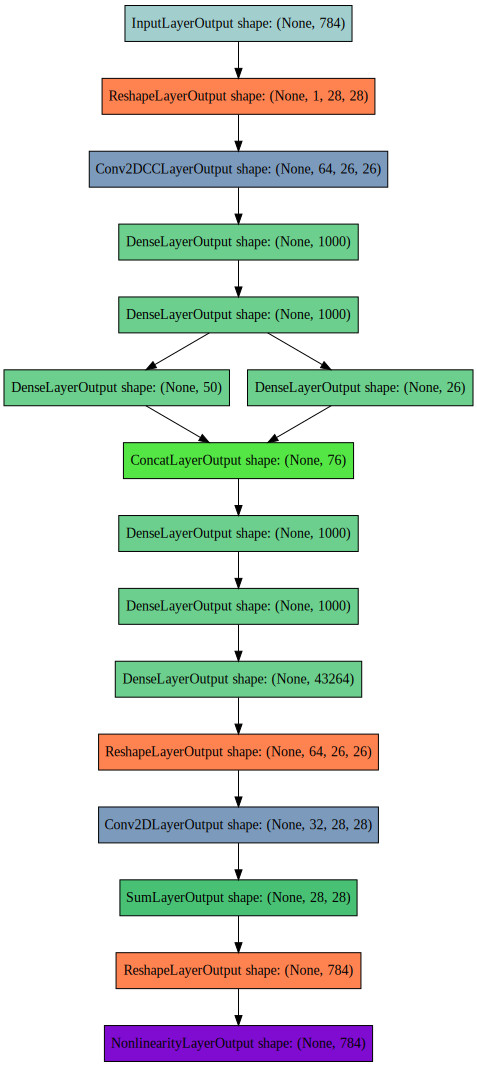

In [12]:
from lasagne.misc.draw_net import draw_to_file
draw_to_file(get_all_layers(l_decoder_out), "model.svg")

from IPython.display import SVG
SVG("model.svg")

## Define the capsule object

The Capsule object combines all the components:

    - The model
    - The training algorithm
    - The loss function

In [13]:

# Define the Capsule object, which combines the Model/Training procedure/Loss function

input_variables = OrderedDict()
input_variables["X"] = dict(tensor_type=T.matrix)
input_variables["y"] = dict(tensor_type=T.matrix)
    

functions = dict(
    encode=dict(
        get_output=lambda model, X:model.x_to_z.get_output(X)[0],
        params=["X"]
    ),
    predict=dict(
        get_output=lambda model, X:(model.x_to_y.get_output(X)[0]).argmax(axis=1),
        params=["X"]
    ),
    reconstruct=dict(
        get_output=lambda model, X: l_decoder_out.get_output(X),
        params=["X"]
    ),
    get_reconstruction_error=dict(
        get_output=lambda model, X: ((X-l_decoder_out.get_output(X))**2).sum(axis=1).mean(),
        params=["X"]
    ),
    get_cross_correlation=dict(
        get_output=lambda model, X: cross_correlation(model.x_to_z.get_output(X)[0],
                                                      model.x_to_y.get_output(X)[0]),
        params=["X"]
    ),
    predict_proba=dict(
        get_output=lambda model, X: model.x_to_y.get_output(X)[0],
        params=["X"]
    )

)

batch_optimizer = MyBatchOptimizer(
    verbose=1,
    max_nb_epochs=200,
    batch_size=100,
    optimization_procedure=(updates.rmsprop, 
                            {"learning_rate": 0.0001})
)



def loss_function(model, tensors):
    x_to_z, x_to_y, z_to_x = model.x_to_z, model.x_to_y, model.z_to_x
    X_batch, y_batch = tensors["X"], tensors["y"]
    
    z, = x_to_z.get_output(X_batch)

    
    y_hat, = x_to_y.get_output(X_batch)
    X_hat, = z_to_x.get_output(y_hat, z)
    
    loss_rec = ((X_hat - X_batch) ** 2).sum(axis=1).mean()
    loss_supervised = ((y_hat - y_batch)**2).sum(axis=1).mean()
    
    return  loss_rec + 5* loss_supervised + 10 * cross_correlation(z, y_hat)
    
capsule = Capsule(
    input_variables, 
    model,
    loss_function,
    functions=functions,
    batch_optimizer=batch_optimizer,
)
Z_batch = T.matrix("z_batch")
capsule.decode = theano.function([Z_batch, capsule.v_tensors["y"]], 
                                  l_decoder_out.get_output({l_latent: Z_batch, 
                                                            l_observed: capsule.v_tensors["y"]}))


/grid_mnt/vol__vol_U__u/gridcl/mehdicherti/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:73: UserWarning: layer.get_output(...) is deprecated and will be removed for the first release of Lasagne. Please use lasagne.layers.get_output(layer, ...) instead.
WARNING (theano.gof.compilelock): Overriding existing lock by dead process '4307' (I am process '8258')


In [14]:
from theano.sandbox.cuda import mem_info
free, m = mem_info()
print(free/(1024.**3), m/(1024.**3))

(4.265724182128906, 4.68707275390625)


## Training 

In [15]:
capsule.fit(X=X[train], y=y[train])

/home/gridcl/mehdicherti/work/code/Lasagne/lasagne/easy.py:857: UserWarning: layer.get_output(...) is deprecated and will be removed for the first release of Lasagne. Please use lasagne.layers.get_output(layer, ...) instead.
  for output_layer in self.output_layers]
/grid_mnt/vol__vol_U__u/gridcl/mehdicherti/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:19: UserWarning: layer.get_output(...) is deprecated and will be removed for the first release of Lasagne. Please use lasagne.layers.get_output(layer, ...) instead.


  epoch    loss_std    loss_train    acc_train    acc_valid    rec_train    rec_valid    crosscor_train    crosscor_valid
-------  ----------  ------------  -----------  -----------  -----------  -----------  ----------------  ----------------
      0     21.0853       42.1766       0.5279       0.5261      22.7616      22.5877         0.0126503         0.0125434
  epoch    loss_std    loss_train    acc_train    acc_valid    rec_train    rec_valid    crosscor_train    crosscor_valid
-------  ----------  ------------  -----------  -----------  -----------  -----------  ----------------  ----------------
      1     2.94588       22.8767       0.7161       0.7067      16.0797      16.2027         0.0243687         0.0235781
  epoch    loss_std    loss_train    acc_train    acc_valid    rec_train    rec_valid    crosscor_train    crosscor_valid
-------  ----------  ------------  -----------  -----------  -----------  -----------  ----------------  ----------------
      2     1.75721     

/grid_mnt/vol__vol_U__u/gridcl/mehdicherti/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:23: UserWarning: layer.get_output(...) is deprecated and will be removed for the first release of Lasagne. Please use lasagne.layers.get_output(layer, ...) instead.


KeyboardInterrupt: 

## Visualization of features

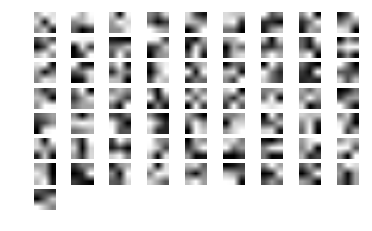

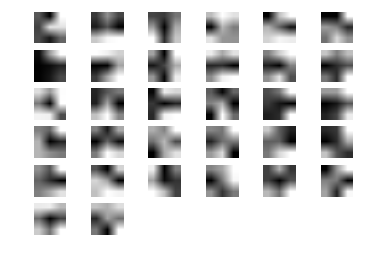

In [16]:
from lasagne.misc.plot_weights import grid_plot

if model_type == "convnet":
    layers_enc = get_all_layers(model.x_to_z.output_layers[0])
    layers_dec = get_all_layers(model.z_to_x.output_layers[0])
    for l in layers_enc[2], layers_dec[-4]:
        plt.clf()
        W = l.W.get_value()[:, 0]
        grid_plot(W, imshow_options={"cmap": "gray"})
        plt.show()
elif model_type == "fully_connected":
    layers_ = get_all_layers(l_decoder_out)
    for W in (layers_[1].W.get_value().T, layers_[-1].W.get_value()):
        plt.clf()
        print(W.shape)
        W = W.reshape((W.shape[0], w, h))
        grid_plot(W, imshow_options={"cmap": "gray"}, nbrows=10, nbcols=10)
        plt.show()

## Statistics

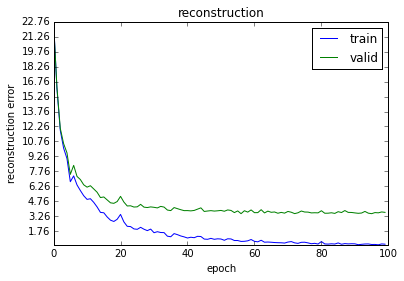

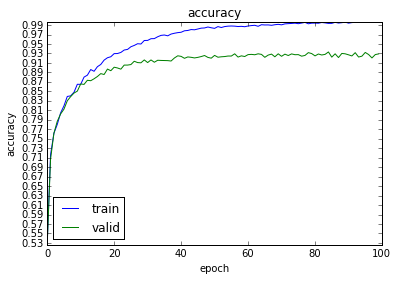

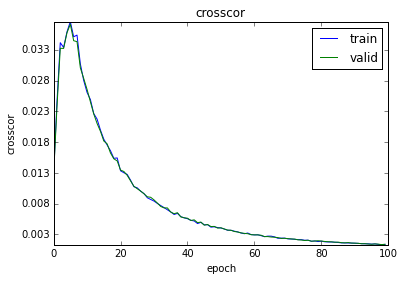

In [17]:
from lasagne.easy import get_stat

layer = 0
train_stat = get_stat("rec_train", capsule.batch_optimizer.stats)
test_stat = get_stat("rec_valid", capsule.batch_optimizer.stats)
plt.yticks(np.arange(round(max(train_stat), 2), round(min(train_stat), 2), -1.5))
plt.plot(train_stat, label="train")
plt.plot(test_stat, label="valid")
plt.xlabel("epoch")
plt.ylabel("reconstruction error")
plt.legend()
plt.title("reconstruction")
plt.savefig("rec.png")
plt.show()

epoch = get_stat("epoch", capsule.batch_optimizer.stats)
acc_train = get_stat("acc_train", capsule.batch_optimizer.stats)
acc_valid = get_stat("acc_valid", capsule.batch_optimizer.stats)
plt.title("accuracy")
plt.yticks(np.arange(round(min(acc_train), 2), round(max(acc_train), 2), 0.02))
plt.plot(acc_train, label="train")
plt.plot(acc_valid, label="valid")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(loc='best')
plt.savefig("acc.png")
plt.show()

epoch = get_stat("epoch", capsule.batch_optimizer.stats)
acc_train = get_stat("crosscor_train", capsule.batch_optimizer.stats)
acc_valid = get_stat("crosscor_valid", capsule.batch_optimizer.stats)
plt.title("crosscor")
plt.yticks(np.arange(round(max(acc_train), 3), round(min(acc_train), 3), -0.005))
plt.plot(acc_train, label="train")
plt.plot(acc_valid, label="valid")
plt.xlabel("epoch")
plt.ylabel("crosscor")
plt.legend(loc='best')
plt.savefig("crosscor.png")
plt.show()

## Interactive sliders

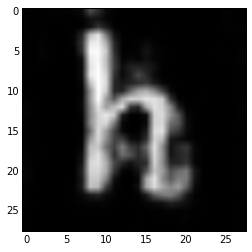

In [18]:

from IPython.html.widgets import (interact, interactive, 
                                  IntSliderWidget, IntSlider, FloatSliderWidget,
                                  ButtonWidget
                                  )
from IPython.display import display # Used to display widgets in the notebook

from IPython.html.widgets import *
from IPython.html import widgets


use_examples = False # init/work with examples for dataset or not
nb = 1000 # nb of examples to consider
max_nb_sliders = 10
T_ = test
x = X[T_][0:nb]


nb_outputs = y.shape[1]



z = capsule.encode(x)

if z.shape[1] > max_nb_sliders:
    params = np.random.choice(z.shape[1],
                              size=10)
else:
    params = np.arange(z.shape[1])

boundaries = OrderedDict()
for p in (params):
    boundaries["{0}".format(p)] = FloatSliderWidget(min=z[:, p].min(),
                                                    max=z[:, p].max(),
                                                    step=0.01,
                                                    value=0.)
d = 0
l = y[T_][d].argmax() 

def draw(**all_params):
    if use_examples is True:
        example = all_params["example"]
        del all_params["example"]
    label = all_params["label"]
    del all_params["label"]
    params = all_params
    
    if use_examples is True:
        z = capsule.encode(x[example:example + 1])
    else:
        z = np.zeros((1, latent_size), dtype="float32")
        z[0, :] = 0
    
    y_ = np.zeros(nb_outputs, dtype='float32')
    y_[label] = 1.
    y_ = y_[np.newaxis, :]
        
    for k, v in params.items():
        z[0][int(k)] = v
    plt.imshow(capsule.decode(z, y_)[0].reshape((w, h)), cmap="gray")
    

p = dict()
p.update(boundaries)

label_selector = IntSliderWidget(min=0,max=9,step=1,value=l)
p["label"] = label_selector

if use_examples is True:
    example_selector = IntSliderWidget(min=0,max=nb-1,step=1,value=d)
    p["example"] = example_selector

i = interact(**p)



def on_button_clicked(b):
    
    example = example_selector.get_state()["value"]
    z = capsule.encode(x[example:example + 1])
    for p in params:
        w = boundaries["{0}".format(p)]
        state = w.get_state()
        state["value"] = z[0, int(p)]
        w.set_state(state)
        w.send_state(state)
        
    state = label_selector.get_state()
    state["value"] = y[example].argmax()
    label_selector.set_state(state)
    label_selector.send_state(state)
    
    
draw_i = i(draw)

if use_examples is True:
    button = widgets.ButtonWidget(description="fit!")
    display(button)
    button.on_click(on_button_clicked)



## Visualizaion of reconstruction of images

In [27]:
nb = 10
x_ = X[test][0:nb]
x_hat_ = capsule.reconstruct(x_)

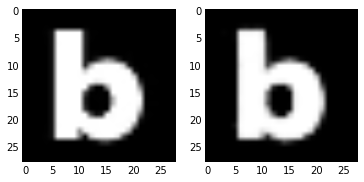

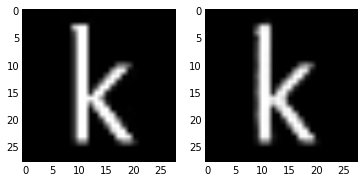

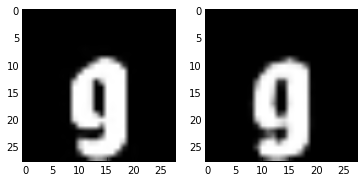

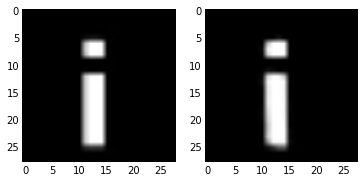

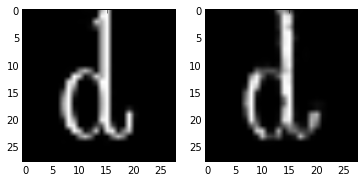

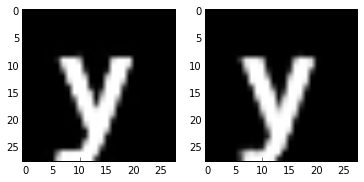

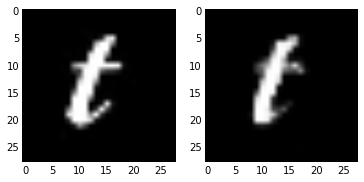

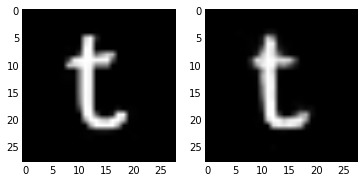

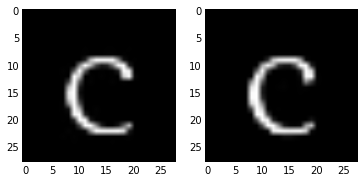

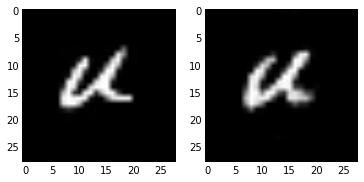

In [28]:
for i in range(nb):
    plt.clf()
    plt.subplot(1, 2, 1)
    plt.imshow(x_[i].reshape((w, h)), cmap="gray")
    plt.subplot(1, 2, 2)
    plt.imshow(x_hat_[i].reshape((w, h)), cmap="gray")
    plt.show()

## 2d histogram of hidden factors

In [21]:
# SOurce :http://oceanpython.org/2013/02/25/2d-histogram/
x_ = X[0:20000]
z = capsule.encode(x_)

# Estimate the 2D histogram
nbins = 200
H, xedges, yedges = np.histogram2d(z[:, 0],z[:, 1],bins=nbins)
 
# H needs to be rotated and flipped
H = np.rot90(H)
H = np.flipud(H)
 
# Mask zeros
Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zero
 
# Plot 2D histogram using pcolor
fig2 = plt.figure()
plt.pcolormesh(xedges,yedges,Hmasked, cmap="afmhot")
plt.xlabel('x')
plt.ylabel('y')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')

MemoryError: Error allocating 3461120000 bytes of device memory (out of memory).
Apply node that caused the error: <pylearn2.sandbox.cuda_convnet.filter_acts.FilterActs object at 0x7ff8c2fabb10>(GpuContiguous.0, GpuContiguous.0)
Inputs types: [CudaNdarrayType(float32, (True, False, False, False)), CudaNdarrayType(float32, 4D)]
Inputs shapes: [(1, 28, 28, 20000), (1, 3, 3, 64)]
Inputs strides: [(0, 560000, 20000, 1), (0, 192, 64, 1)]
Inputs values: ['not shown', 'not shown']

Backtrace when the node is created:
  File "/home/gridcl/mehdicherti/work/code/Lasagne/lasagne/layers/base.py", line 120, in get_output
    return get_output(self, input, **kwargs)

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

## Checking the gaussianity of the hidden factors

In [29]:
from scipy.stats import kurtosistest
import numpy as np
x_ = X[0:10000]
z = capsule.encode(x_)

_, pvalues = kurtosistest(z)
print(pvalues)

RuntimeError: c_extract: Some CudaNdarray has rank -1, it was supposed to have rank 4
Apply node that caused the error: <pylearn2.sandbox.cuda_convnet.filter_acts.FilterActs object at 0x7ff8c2fabb10>(GpuContiguous.0, GpuContiguous.0)
Inputs types: [CudaNdarrayType(float32, (True, False, False, False)), CudaNdarrayType(float32, 4D)]
Inputs shapes: [(1, 28, 28, 10000), (1, 3, 3, 64)]
Inputs strides: [(0, 280000, 10000, 1), (0, 192, 64, 1)]
Inputs values: ['not shown', 'not shown']

Backtrace when the node is created:
  File "/home/gridcl/mehdicherti/work/code/Lasagne/lasagne/layers/base.py", line 120, in get_output
    return get_output(self, input, **kwargs)

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

## Covariance matrix of hidden factors

In [22]:
x_ = X[0:5000]
z = capsule.encode(x_)
print(z.mean(axis=0))
plt.matshow(np.abs(np.corrcoef(z.T)))
plt.colorbar()
np.save("hidfact_corr{0}_{1}".format(latent_size, model_type), np.corrcoef(z.T))

RuntimeError: c_extract: Some CudaNdarray has rank -1, it was supposed to have rank 4
Apply node that caused the error: <pylearn2.sandbox.cuda_convnet.filter_acts.FilterActs object at 0x7ff8c2fabb10>(GpuContiguous.0, GpuContiguous.0)
Inputs types: [CudaNdarrayType(float32, (True, False, False, False)), CudaNdarrayType(float32, 4D)]
Inputs shapes: [(1, 28, 28, 5000), (1, 3, 3, 64)]
Inputs strides: [(0, 140000, 5000, 1), (0, 192, 64, 1)]
Inputs values: ['not shown', 'not shown']

Backtrace when the node is created:
  File "/home/gridcl/mehdicherti/work/code/Lasagne/lasagne/layers/base.py", line 120, in get_output
    return get_output(self, input, **kwargs)

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

## Latent order by variance

In [23]:
x_ = X[0:5000]
z = capsule.encode(x_)

C = np.cov(z.T)
latent_order = np.argsort(np.diag(C))[::-1]
print(latent_order)

RuntimeError: c_extract: Some CudaNdarray has rank -1, it was supposed to have rank 4
Apply node that caused the error: <pylearn2.sandbox.cuda_convnet.filter_acts.FilterActs object at 0x7ff8c2fabb10>(GpuContiguous.0, GpuContiguous.0)
Inputs types: [CudaNdarrayType(float32, (True, False, False, False)), CudaNdarrayType(float32, 4D)]
Inputs shapes: [(1, 28, 28, 5000), (1, 3, 3, 64)]
Inputs strides: [(0, 140000, 5000, 1), (0, 192, 64, 1)]
Inputs values: ['not shown', 'not shown']

Backtrace when the node is created:
  File "/home/gridcl/mehdicherti/work/code/Lasagne/lasagne/layers/base.py", line 120, in get_output
    return get_output(self, input, **kwargs)

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

## Visualization of samples when varying hidden factors

In [30]:
from lasagne.misc.plot_weights import grid_plot
nb = 10# nb of different hidden factors values to consider
labels = np.arange(output_dim)# labels to consider (by default, all)
labels = np.arange(10)
std_units=2# nb of std units of values of latent dim around the mean to consider
L = latent_size

x_ = X[train][0:100]
z_ = capsule.encode(x_)
latent_std = np.std(z_, axis=0)
latent_mean = np.mean(z_, axis=0)

k = 1
for latent_dim in latent_order:
    print("hidden factor : {0}".format(latent_dim))
    ys = np.eye(output_dim)[labels].repeat(nb, axis=0)
    seq = np.linspace(latent_mean[latent_dim] - latent_std[latent_dim]*std_units,
                      latent_mean[latent_dim] + latent_std[latent_dim]*std_units,
                      nb)
    z = np.zeros((nb, L))
    z[:, latent_dim] = seq
    z = z.repeat(len(labels), axis=0)
    z = z.reshape((nb, len(labels), L))
    z = z.transpose((1, 0, 2))
    z = z.reshape((nb*len(labels), L))
    z = z.astype(np.float32)
    ys = ys.astype(np.float32)

    c = capsule.decode(z, ys)
    c = c.reshape((c.shape[0], w, h))
    plt.clf()
    grid_plot(c, imshow_options=dict(cmap="gray"), nbrows=len(labels), nbcols=nb)
    plt.savefig("hidfactor{0}.png".format(k))
    plt.show()
    k += 1

RuntimeError: c_extract: Some CudaNdarray has rank -1, it was supposed to have rank 4
Apply node that caused the error: <pylearn2.sandbox.cuda_convnet.filter_acts.FilterActs object at 0x7ff8c2fabb10>(GpuContiguous.0, GpuContiguous.0)
Inputs types: [CudaNdarrayType(float32, (True, False, False, False)), CudaNdarrayType(float32, 4D)]
Inputs shapes: [(1, 28, 28, 100), (1, 3, 3, 64)]
Inputs strides: [(0, 2800, 100, 1), (0, 192, 64, 1)]
Inputs values: ['not shown', 'not shown']

Backtrace when the node is created:
  File "/home/gridcl/mehdicherti/work/code/Lasagne/lasagne/layers/base.py", line 120, in get_output
    return get_output(self, input, **kwargs)

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.